## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

- [ ] Create function to test multiple models

In [19]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
import numpy as np
import hydra
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import copy
import itertools

In [10]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [11]:
data_folder = 'data'
data_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
data_train = pd.read_csv(os.path.join(data_folder, data_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
# transform week_start_date into a datetime feature
data_train['week_start_date'] = data_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)
# Merge features and labels for easier exploration
data_df = data_train.merge(labels_train, on=['city', 'year', 'weekofyear'])
fill_ma_cols = [col for col in data_df.columns if data_df[data_df[col].isna()].shape[0] > 0]
for col in tqdm(fill_ma_cols):
    fill_ma(data_df, col)
data_df['weekofyear'] = data_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
def get_data(data_df_in):
    data_df = copy.deepcopy(data_df_in)
    iq_train_years = sorted(data_df[data_df.city == 'iq'][['year']].drop_duplicates().values)[:int(data_df[data_df.city == 'iq'][['year']].nunique() * 0.8)]
    iq_eval_years = sorted(data_df[data_df.city == 'iq'][['year']].drop_duplicates().values)[int(data_df[data_df.city == 'iq'][['year']].nunique() * 0.8):]
    sj_train_years = sorted(data_df[data_df.city == 'sj'][['year']].drop_duplicates().values)[:int(data_df[data_df.city == 'sj'][['year']].nunique() * 0.8)]
    sj_eval_years = sorted(data_df[data_df.city == 'sj'][['year']].drop_duplicates().values)[int(data_df[data_df.city == 'sj'][['year']].nunique() * 0.8):]
    eval_df = data_df[(data_df.city == 'sj') & (data_df.year.isin(sj_eval_years)) | (data_df.city == 'iq') & (data_df.year.isin(iq_eval_years))]
    train_df = data_df[(data_df.city == 'sj') & (data_df.year.isin(sj_train_years)) | (data_df.city == 'iq') & (data_df.year.isin(iq_train_years))]
    return train_df, eval_df

In [16]:
%%time
train_df, eval_df = get_data(data_df)

CPU times: user 25.5 ms, sys: 2.07 ms, total: 27.6 ms
Wall time: 25.9 ms


In [27]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [28]:
confs = {
    'models' : ['sklearn.neural_network.MLPRegressor',
              'sklearn.svm.SVR'
             ],
    'scaler' : [None, 'sklearn.preprocessing.StandardScaler', 'sklearn.preprocessing.MinMaxScaler']
}

In [32]:
for model, scaler in tqdm([*itertools.product(*confs.values())]):
    print(model, scaler)
    train_df, eval_df = get_data(data_df)
    features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
    label_train = train_df[TARGET]
    features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
    label_eval = eval_df[TARGET]
    clf = hydra.utils.get_class(model)()
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    print(mean_absolute_error(label_eval, y_hat))

  0%|          | 0/6 [00:00<?, ?it/s]

sklearn.neural_network.MLPRegressor None
34.518609290774
sklearn.neural_network.MLPRegressor sklearn.preprocessing.StandardScaler


/Users/lbasla002/Envs/dengai/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/lbasla002/Envs/dengai/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


33.68604017239179
sklearn.neural_network.MLPRegressor sklearn.preprocessing.MinMaxScaler
34.996463887725376
sklearn.svm.SVR None


/Users/lbasla002/Envs/dengai/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


26.690790053808517
sklearn.svm.SVR sklearn.preprocessing.StandardScaler
26.690790053808517
sklearn.svm.SVR sklearn.preprocessing.MinMaxScaler
26.690790053808517


In [687]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [527]:
clf.feature_names_in_

array(['weekofyear', 'ndvi_ne', 'reanalysis_specific_humidity_g_per_kg',
       'station_avg_temp_c', 'station_precip_mm', 'city_iq', 'city_sj'],
      dtype=object)

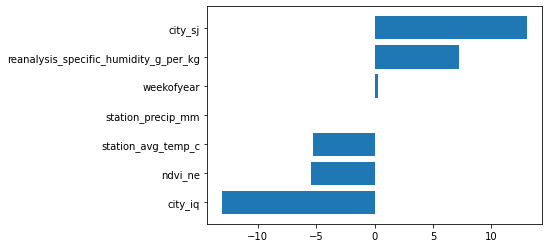

In [528]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(clf.coef_[0], clf.feature_names_in_)

### One model per city

In [461]:
initial_list = [
    'weekofyear',
#  'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
#  'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [462]:
y_real = []
y_pred = []
for city in ['sj', 'iq']:
    features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
    labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
    features_test = pd.read_csv(os.path.join(data_folder, features_test_path))
    # transform week_start_date into a datetime feature
    
    features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)
    
    # Merge features and labels for easier exploration
    train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])
    
    fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
    for col in tqdm(fill_ma_cols):
        fill_ma(train_df, col)
    train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)
    train_years = sorted(train_df[train_df.city == city][['year']].drop_duplicates().values)[:int(train_df[train_df.city == city][['year']].nunique() * 0.8)]
    eval_years = sorted(train_df[train_df.city == city][['year']].drop_duplicates().values)[int(train_df[train_df.city == city][['year']].nunique() * 0.8):]

    eval_df = train_df[(train_df.city == city) & (train_df.year.isin(eval_years))]
    train_df = train_df[(train_df.city == city) & (train_df.year.isin(train_years))]
    
    TARGET = 'total_cases'
    ignore_cols = ['week_start_date'] + [TARGET]
    num_cols = [col for col in initial_list if col not in ignore_cols]
    
    features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
    label_train = train_df[TARGET]
    features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
    label_eval = eval_df[TARGET]
    
    model = 'sklearn.svm.SVR'
    clf = hydra.utils.get_class(model)(kernel='linear')
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    y_pred.extend(y_hat)
    y_real.extend(label_eval)
    print(city, mean_absolute_error(label_eval, y_hat))
print(mean_absolute_error(y_real, y_pred))

  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

sj 29.269045462044097


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

iq 13.044167749490034
24.227051591210557


### Scaled features

In [98]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [99]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [100]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [101]:
scaler = preprocessing.StandardScaler().fit(features_train)
# scaler = preprocessing.MinMaxScaler().fit(features_train)

In [102]:
features_train = scaler.transform(features_train)
features_eval = scaler.transform(features_eval)
#scaler = preprocessing.MinMaxScaler().fit(features_train)
#features_train = scaler.transform(features_train)
#features_eval = scaler.transform(features_eval)

In [103]:
model = 'sklearn.svm.SVR'

In [104]:
clf = hydra.utils.get_class(model)()#(kernel='linear')

In [57]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [105]:
clf = clf.fit(features_train, label_train)

In [106]:
y_hat = clf.predict(features_eval)

In [107]:
mean_absolute_error(label_eval, y_hat)

21.160166863290996